In [1]:
import numpy as np
import pickle as pkl

# Probability estimate

In [13]:

p = 3*1e-4
n = 50000
cv = np.sqrt((1-p)/(n*p))
cv

0.25816015700852574

In [2]:
with open("results/sim_estimates", "rb") as fp:
    results = pkl.load(fp)

In [3]:
#Empirircal CV
np.mean(results), np.std(results), np.std(results)/np.mean(results)

(0.00037547584000000006, 0.00010843377363448347, 0.28879028177813904)

In [12]:
#IC (given that the estimator is asymptotically normal)
np.mean(results) - 1.96*np.std(results)/np.sqrt(100), np.mean(results) + 1.96*np.std(results)/np.sqrt(100)

(0.0003542228203676413, 0.00039672885963235884)

In [33]:
#Number of evaluations per simulation
cost = []
for i in range(100):
    with open("results/subset_sampling_"+str(i)+".pkl", "rb") as f:
        ss_res = pkl.load(f)
        n_eval = len(ss_res["g"]) * len(ss_res["g"][0])
        cost.append(n_eval)
        
#Mean cost per simulation
np.mean(cost)

53000.0

# Failure domain

In [1]:
from deep_traffic_generation.tcvae_pairs_disent import TCVAE_Pairs_disent
from deep_traffic_generation.VAE_Generation import PairsVAE
from traffic.algorithms.generation import Generation
from deep_traffic_generation.core.datasets import TrafficDatasetPairsRandom
from traffic.core import Traffic

from subset_simulation import subsim, subsim_curve

import openturns as ot
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np

In [4]:
dataset = TrafficDatasetPairsRandom.from_file(
    ("../../deep_traffic_generation/data/training_datasets/to_LSZH_16_50_bb.pkl", "../../deep_traffic_generation/data/training_datasets/ga_LSZH_14_50_bb.pkl"),
    features=["track", "groundspeed", "altitude", "timedelta"],
    n_samples = 10000,
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

path = "../../deep_traffic_generation/lightning_logs/tcvae_pairs_disent/version_22/"

t = PairsVAE(X = dataset, vae_type="TCVAEPairs_disent", sim_type = "generation")
t.load(path, dataset.parameters)
gen_vae = Generation(generation=t, features = t.VAE.hparams.features, scaler=dataset.scaler)

In [5]:
Z = t.latent_space(0)
p_z = t.VAE.lsr.get_prior()

#Create the multivariate distrib with 1d gmm on each dimension
marginals = []
for i in range(Z.shape[1]):
    collDist = [ot.Normal(mu.item(), sigma.item()) for mu, sigma in zip(p_z.base_dist.component_distribution.base_dist.loc.squeeze(2)[i], p_z.base_dist.component_distribution.base_dist.scale.squeeze(2)[i])]
    weights = p_z.base_dist.mixture_distribution.probs[i].detach().numpy()
    mixt = ot.Mixture(collDist, weights)
    marginals.append(mixt)
prior = ot.ComposedDistribution(marginals)

# isoproba transformation from N(0,1) to prior
isoTrans = prior.getInverseIsoProbabilisticTransformation()

9970


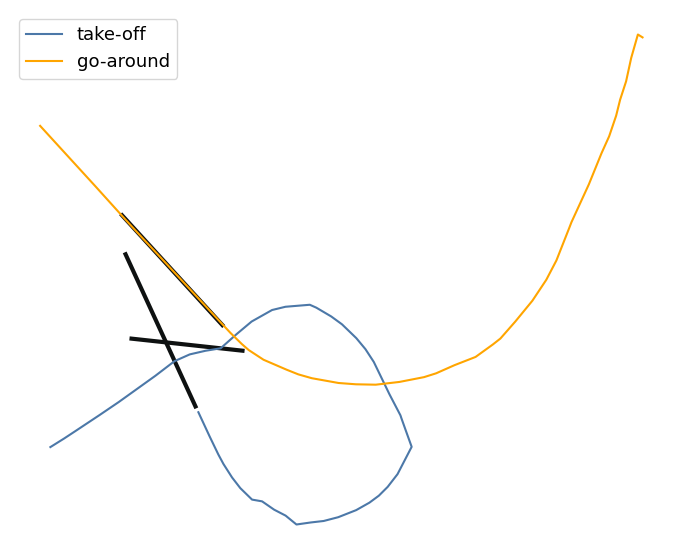

In [12]:
from traffic.core.projection import EuroPP
from traffic.data import airports
from traffic.drawing import countries
import pickle as pkl

with open("results/subset_sampling_0.pkl", "rb") as f:
        ss_res = pkl.load(f)
        theta = ss_res["theta"]
        g = ss_res["g"]

j = np.random.randint(len(theta[-1]))
print(j)

#Reconstruction
z = isoTrans(ot.Point(theta[-1][j]))
decoded = t.decode(torch.Tensor(z).unsqueeze(0))
reconstructed_to = gen_vae.build_traffic(decoded[:,:200], coordinates = dict(latitude =  47.44464, longitude = 8.55732), forward=True).resample("1s").eval()
reconstructed_to = reconstructed_to.assign(flight_id=lambda x: x.flight_id + "_to", inplace=True)
reconstructed_ga = gen_vae.build_traffic(decoded[:,200:], coordinates = dict(latitude = 47.500086, longitude = 8.51149), forward=True).resample("1s").eval()
reconstructed_ga = reconstructed_ga.assign(flight_id=lambda x: x.flight_id + "_ga", inplace=True)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, subplot_kw=dict(projection=EuroPP()))
    reconstructed_to.plot(ax, c="#4c78a8", label = "take-off")
    reconstructed_ga.plot(ax, c="orange", label = "go-around")
    plt.legend()

    airports["LSZH"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)

    plt.show()